# Preparation

## Install Prerequisites

The following platform(s) are tested:

- Windows 10 + CUDA 11.0.2 + Python 3.9.9 (with GPU)

In [203]:
import sys
import subprocess as sp
import typing as t
def module(mod_args: t.Union[list[str], str], **kw):
    'Run a module from currently-running python executable'
    return sp.Popen((sys.executable, '-m',
                    *(mod_args.split()
                     if isinstance(mod_args, str)
                     else mod_args)), **kw).wait()

# import all required packages
# Tested on Windows 10
module(r'''pip install -q --user
    torch=1.10.0+cu113
    transformers datasets numpy pandas wordninja spacy
    sqlalchemy psycopg2
    matplotlib
''');
module(r'spacy download en_core_web_sm');

In [204]:
import warnings
warnings.filterwarnings('ignore')

## Create connection

In [224]:
from sqlalchemy import create_engine
from regal_swans_private import sql_url, sql_pass as _
engine = create_engine(sql_url, pool_recycle=3600)
conn = engine.connect()

## Load Packages and NLP Data

In [206]:
# change to None if not using a GPU,
# or any other index if non-default GPU
gpu_index = 0

In [207]:
from transformers import (pipeline as _pipeline, BertTokenizer)
from collections import Counter
from spacy.tokens import Token
from spacy.matcher import Matcher
from spacy.strings import StringStore
from copy import deepcopy
import spacy
import torch
import re
import wordninja as wn
import numpy as np
import pandas as pd
import functools as ft

tokenize = spacy.load('en_core_web_sm')

pipeline = (ft.partial(_pipeline, device=gpu_index)
            if gpu_index is not None else _pipeline)

In [208]:
# prepare analyzer
sentiment_analyzer = pipeline('sentiment-analysis')
sentiment_analyzer = (lambda f:
    lambda *a, **kw:f(*a, **kw)[0])(sentiment_analyzer)
# well, only allow at most 512 characters
sentiment_analyzer = (lambda f:
    lambda s: f(s[:512]))(sentiment_analyzer)
def sentiment_score(sentiment):
    import math
    if isinstance(sentiment, int): return sentiment
    negative = sentiment['label'] == 'NEGATIVE'
    score = math.log(1 - sentiment['score'])
    return round(score, 2) * (1 if negative else -1)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [209]:
# clean text
def clean(text: str):
    if text.lower() in (
        '(none entered)', 'no affidavit'): return ''
    
    text = text \
        .replace('\n', ' ') \
        .replace('|', 'I') \
        .replace('Initial / In take Allegation ', '') \
        .replace(':', '') \
        .replace('Finding ', '') \
        .strip()
    
    text = ' '.join(
        word
        for token in text.split()
        for word in (
            wn.split(token)
            if token.isalpha()
            else (token,)))
    return text.lower()

In [210]:
# helper functions for debugging
first = lambda seq: next(iter(seq))

# Part 1
**Do repeat police officers receive more severe allegations across their careers?**

In [211]:
# keep a copy for debug & backup purposes

# del _allegations
_allegations = pd.read_sql(
    r'''SELECT
            crid,    -- str
            summary, -- str
            (DATE_PART('YEAR',CURRENT_DATE)-
            DATE_PART('YEAR',org_hire_date))::INT emp_years
        FROM data_allegation da
        JOIN data_officerallegation doa
        ON da.crid = doa.allegation_id
        JOIN data_salary ds
        ON doa.officer_id = ds.officer_id''',
    conn) if '_allegations' not in locals() else _allegations

In [212]:
# copy table
allegations = deepcopy(_allegations)

In [213]:
# drop repeated rows
allegations.drop_duplicates(inplace=True)

In [214]:
# clean up text
allegations.summary = allegations.summary.map(clean)
allegations = allegations[
    allegations.summary.map(lambda e:e or '') != '']

In [215]:
# add a sentiment column
allegations = allegations \
    .assign(sentiment=allegations.summary)
allegations.sentiment = \
    allegations.sentiment \
    .map(sentiment_analyzer) \
    .map(sentiment_score)

Normalized covariance between "Years of Employment" and "Sentiment Score":
-0.10993363176110868


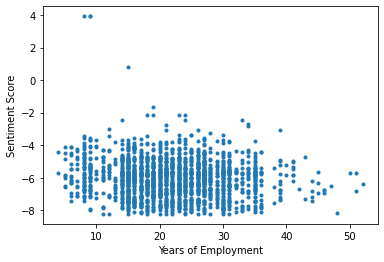

In [216]:
import matplotlib.pyplot as plt
plt.plot(allegations.emp_years,
         allegations.sentiment,
         '.');
plt.xlabel('Years of Employment');
plt.ylabel('Sentiment Score');

cor = np.corrcoef(
    allegations.emp_years, allegations.sentiment)[1][0]
print('Normalized covariance between '
      '"Years of Employment" '
      'and "Sentiment Score":\n'
      f'{cor}''')

Conclusion from the covariance and scatter plot: there is an **insignificant** correlation between the years of employment (i.e., experience) and the sentiment score (i.e., the severity of allegations).

# Part 2
**Are lawsuits likely to include the experience of officers as either an aggravating factor or a redeeming quality?**

In [217]:
# keep a copy for debug & backup purposes

# del _lawsuits
_lawsuits = pd.read_sql(
    r'''SELECT
            lawsuit_id,         -- int
            summary,            -- str
            total_payments pay, -- int
            (DATE_PART('YEAR',CURRENT_DATE)-
            DATE_PART('YEAR',org_hire_date))::INT emp_years
        FROM data_salary ds
        JOIN lawsuit_lawsuit_officers llo
        ON ds.officer_id = llo.officer_id
        JOIN lawsuit_lawsuit ll
        ON ll.id = llo.lawsuit_id''',
    conn) if '_lawsuits' not in locals() else _lawsuits

In [218]:
lawsuits = deepcopy(_lawsuits)

In [219]:
lawsuits.drop_duplicates(inplace=True)

In [220]:
lawsuits = lawsuits \
    .assign(
        sentiment=lawsuits.summary
            .map(sentiment_analyzer)
            .map(sentiment_score),
        log_pay=lawsuits.pay.map(np.log))

Normalized covariance between "Years of Employment" and "Lawsuit Sentiment Score":
-0.004092973027721347


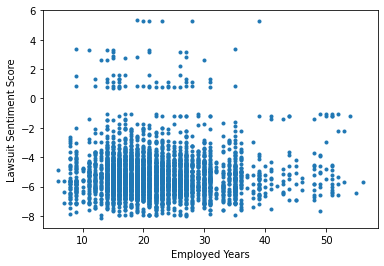

In [222]:
import matplotlib.pyplot as plt
plt.plot(lawsuits.emp_years, lawsuits.sentiment, '.')
plt.xlabel('Employed Years')
plt.ylabel('Lawsuit Sentiment Score')
cor_evs = np.corrcoef(lawsuits.emp_years, lawsuits.sentiment)[1][0]
print('Normalized covariance between '
      '"Years of Employment" '
      'and "Lawsuit Sentiment Score":\n'
      f'{cor_evs}''')

From the scatter plot above and the resultant covariance coefficient, we conclude that there is virtually no correlation between the years of employment and the severity of the lawsuit.